In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Alpha import Alpha

Part 1. Read data and create alphas (without operations on alphas). Do if you don't have alpha's weights on your local.

In [4]:
# READ DATA

close_df = pd.read_parquet('binance/close.parquet')
vwap_df = pd.read_parquet('binance/vwap.parquet')
buy_volume_df = pd.read_parquet('binance/buy_volume.parquet')
sell_volume_df = pd.read_parquet('binance/sell_volume.parquet')
mo1_sell_count_df = pd.read_parquet('binance/mo1_sell_count.parquet')
mo0_sell_count_df = pd.read_parquet('binance/mo0_sell_count.parquet')
ask_10_size_df = pd.read_parquet('binance/ask_10_size.parquet')
bid_10_size_df = pd.read_parquet('binance/bid_10_size.parquet')

close_df = close_df.ffill(limit=3)
vwap_df = vwap_df.fillna(close_df)

# ALPHA FORMULAS

REVERSION_WEIGHTS = - close_df.pct_change()
REVERSION_WEIGHTS.to_parquet("raw_alpha_weights/REVERSION_WEIGHTS.gzip", compression='gzip')

DIRECTED_VOLUME_WEIGHTS = sell_volume_df / (buy_volume_df + sell_volume_df)
DIRECTED_VOLUME_WEIGHTS.to_parquet("raw_alpha_weights/DIRECTED_VOLUME_WEIGHTS.gzip", compression='gzip')

MO_SELL_BREAK_WEIGHTS = mo1_sell_count_df / mo0_sell_count_df
MO_SELL_BREAK_WEIGHTS.to_parquet("raw_alpha_weights/MO_BREAK_WEIGHTS.gzip", compression='gzip')

QUANTILE_10_SIZE_WEIGHTS = bid_10_size_df / ask_10_size_df
QUANTILE_10_SIZE_WEIGHTS.to_parquet("raw_alpha_weights/QUANTILE_10_SIZE_WEIGHTS.gzip", compression='gzip')

/var/folders/tz/v_hg3lns6cld3d61vl4lcxp9bzd_1w/T/ipykernel_64692/2430021395.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  REVERSION_WEIGHTS = - close_df.pct_change()


In [5]:
filtered_tickers = pd.read_csv("filtered_tickers.csv", index_col=0).iloc[:, 0].to_list()

Part 2. Create alpha's objects from local files with raw weights. Operations on alphas. Show metrics.

In [2]:
close_df = pd.read_parquet("binance/close.parquet")
vwap_df = pd.read_parquet("binance/vwap.parquet")

# EMPTY TICKERS OR TICKERS WITH GAP

TICKERS_WITH_GAP = ['AAVEDOWN-USDT', 'BNBDOWN-USDT', 'DOTDOWN-USDT', 'DREP-USDT',
       'ETHDOWN-USDT', 'LINKDOWN-USDT', 'LTCDOWN-USDT', 'LUNA-USDT',
       'SUSHIDOWN-USDT', 'SXPDOWN-USDT', 'TRXDOWN-USDT', 'UNIDOWN-USDT',
       'XLMDOWN-USDT', 'XTZDOWN-USDT', 'YFIDOWN-USDT']

BLOCK_TICKERS = []

yy = close_df.dropna(how='all', axis=1)
BLOCK_TICKERS = list(set(close_df.columns).difference(set(yy.columns)))
BLOCK_TICKERS.extend(TICKERS_WITH_GAP)

filtered_tickers = list(set(close_df.columns).difference(set(BLOCK_TICKERS)))

In [3]:
# CREATE ALPHA OBJECTS

REVERSION_WEIGHTS = pd.read_parquet("raw_alpha_weights/REVERSION_WEIGHTS.gzip")
REVERSION_ALPHA = Alpha(REVERSION_WEIGHTS, close_df, vwap_df)
REVERSION_ALPHA.filter_tickers(filtered_tickers)
REVERSION_ALPHA.truncate_and_normalize(0.05)
REVERSION_ALPHA.decay(15)

DIRECTED_VOLUME_WEIGHTS = pd.read_parquet("raw_alpha_weights/DIRECTED_VOLUME_WEIGHTS.gzip")
DIRECTED_VOLUME_ALPHA = Alpha(DIRECTED_VOLUME_WEIGHTS, close_df, vwap_df)
DIRECTED_VOLUME_ALPHA.filter_tickers(filtered_tickers)
DIRECTED_VOLUME_ALPHA.truncate_and_normalize(0.05)
DIRECTED_VOLUME_ALPHA.decay(9)

MO_SELL_BREAK_WEIGHTS = pd.read_parquet("raw_alpha_weights/MO_BREAK_WEIGHTS.gzip")
MO_SELL_BREAK_ALPHA = Alpha(MO_SELL_BREAK_WEIGHTS, close_df, vwap_df)
MO_SELL_BREAK_ALPHA.filter_tickers(filtered_tickers)
MO_SELL_BREAK_ALPHA.truncate_and_normalize(0.05)
MO_SELL_BREAK_ALPHA.decay(7)

QUANTILE_10_SIZE_WEIGHTS = pd.read_parquet("raw_alpha_weights/QUANTILE_10_SIZE_WEIGHTS.gzip")
QUANTILE_10_SIZE_ALPHA = Alpha(QUANTILE_10_SIZE_WEIGHTS, close_df, vwap_df)
QUANTILE_10_SIZE_ALPHA.filter_tickers(filtered_tickers)
QUANTILE_10_SIZE_ALPHA.truncate_and_normalize(0.05)
QUANTILE_10_SIZE_ALPHA.decay(4)

LSTM_WEIGHTS = pd.read_parquet("raw_alpha_weights/LSTM_WEIGHTS.gzip")
LSTM_ALPHA = Alpha(LSTM_WEIGHTS, close_df, vwap_df)
LSTM_ALPHA.filter_tickers(filtered_tickers)
LSTM_ALPHA.truncate_and_normalize(0.05)
LSTM_ALPHA.decay(6)

CNN_WEIGHTS = pd.read_parquet("raw_alpha_weights/CNN_WEIGHTS.gzip")
CNN_ALPHA = Alpha(CNN_WEIGHTS, close_df, vwap_df)
CNN_ALPHA.filter_tickers(filtered_tickers)
CNN_ALPHA.truncate_and_normalize(0.05)
CNN_ALPHA.decay(7)

In [4]:
# CHOOSE DATE PERIOD

start_period = pd.Timestamp('2020-09-01T00:00:00')
end_period = pd.Timestamp('2023-01-01T00:00:00')

REVERSION_ALPHA.set_reversion_window(window=3)

REVERSION_ALPHA.filter_date((start_period, end_period))
DIRECTED_VOLUME_ALPHA.filter_date((start_period, end_period))
MO_SELL_BREAK_ALPHA.filter_date((start_period, end_period))
QUANTILE_10_SIZE_ALPHA.filter_date((start_period, end_period))
LSTM_ALPHA.filter_date((start_period, end_period))
CNN_ALPHA.filter_date((start_period, end_period))

Reversion

Annualized Sharpe Ratio = 13.95
Daily tvr = 484.1%
Annual return = 306.91%
Max Drawdown = -6.07%
Margin = 0.0 bp

Directed_Volume

Annualized Sharpe Ratio = 12.07
Daily tvr = 485.33%
Annual return = 49.81%
Max Drawdown = -1.39%
Margin = 0.0 bp

MO_Sell_Break

Annualized Sharpe Ratio = 4.44
Daily tvr = 461.49%
Annual return = 50.04%
Max Drawdown = -8.8%
Margin = 0.0 bp

Quantile_Size

Annualized Sharpe Ratio = 18.52
Daily tvr = 464.24%
Annual return = 304.61%
Max Drawdown = -3.89%
Margin = 0.0 bp

LSTM

Annualized Sharpe Ratio = 9.05
Daily tvr = 500.32%
Annual return = 161.27%
Max Drawdown = -17.17%
Margin = 0.0 bp

CNN

Annualized Sharpe Ratio = 4.32
Daily tvr = 476.77%
Annual return = 134.32%
Max Drawdown = -25.01%
Margin = 0.0 bp



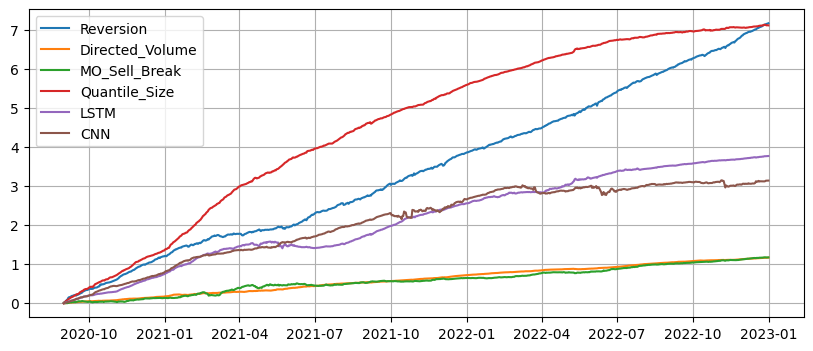

In [6]:
# SHOW METRICS

plt.figure(figsize=(10, 4))
REVERSION_ALPHA.backtest(display=True, label="Reversion")
DIRECTED_VOLUME_ALPHA.backtest(display=True, label="Directed_Volume")
MO_SELL_BREAK_ALPHA.backtest(display=True, label="MO_Sell_Break")
QUANTILE_10_SIZE_ALPHA.backtest(display=True, label="Quantile_Size")
LSTM_ALPHA.backtest(display=True, label="LSTM")
CNN_ALPHA.backtest(display=True, label="CNN")


plt.legend()
plt.grid()

In [7]:
PNL_ALPHAS = pd.DataFrame()
PNL_ALPHAS['REVERSION_PNL'] = REVERSION_ALPHA.metrics["daily_pnl"]
PNL_ALPHAS['DIRECTED_VOLUME_PNL'] = DIRECTED_VOLUME_ALPHA.metrics["daily_pnl"]
PNL_ALPHAS['MO_SELL_BREAK_PNL'] = MO_SELL_BREAK_ALPHA.metrics["daily_pnl"]
PNL_ALPHAS['QUANTILE_10_SIZE_PNL'] = QUANTILE_10_SIZE_ALPHA.metrics["daily_pnl"]
PNL_ALPHAS['LSTM_PNL'] = LSTM_ALPHA.metrics["daily_pnl"]
PNL_ALPHAS['CNN_PNL'] = CNN_ALPHA.metrics["daily_pnl"]

PNL_ALPHAS.corr()

,REVERSION_PNL,DIRECTED_VOLUME_PNL,MO_SELL_BREAK_PNL,QUANTILE_10_SIZE_PNL,LSTM_PNL,CNN_PNL
REVERSION_PNL,1.000000,0.323948,-0.038471,0.029374,0.120214,0.107288
DIRECTED_VOLUME_PNL,0.323948,1.000000,0.105580,0.131485,0.119238,0.048143
MO_SELL_BREAK_PNL,-0.038471,0.105580,1.000000,0.022170,0.075464,0.057948
QUANTILE_10_SIZE_PNL,0.029374,0.131485,0.022170,1.000000,0.205782,0.137092
LSTM_PNL,0.120214,0.119238,0.075464,0.205782,1.000000,-0.095515
CNN_PNL,0.107288,0.048143,0.057948,0.137092,-0.095515,1.000000
